In [1]:
import gzip
import gc
import math
import json
from collections import Counter, defaultdict
import random
from tqdm.notebook import tqdm
import numpy as np
import sys
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

def jl_to_list(fname):
    output = []
    with gzip.open(fname, "rb") as f:
        for line in f:
            output.append(json.loads(line))
    return output

### Load user data

In [3]:
samples = None
test_size = .2
rows = jl_to_list("../data/train_dataset.jl.gz")
if samples:
    rows = rows[:samples]

### Train-test split

In [4]:
val_size = .15
rows_train, rows_test = train_test_split(rows, test_size = test_size, random_state = 42)
print(f"Train data: {len(rows_train)}.")
print(f"Test data: {len(rows_test)}.")

Train data: 330530.
Test data: 82633.


### Load items

In [ ]:
item_data = jl_to_list("../data/item_data.jl.gz")

### Save item title strings

In [7]:
file = open("titles.txt", "wt")
max_tok = 0
max_title = None
tokens_hist = []
words_ = []
word_counter = Counter()
for item in tqdm(item_data):
    title = item["title"]
    words = list(title.lower().split())
    words_ += words
    for w in words:
        word_counter[w] += 1
    tokens = len(words)
    tokens_hist.append(tokens)
    if tokens > max_tok and tokens <= 15:
        max_tok = tokens
        max_title = title
    file.write(title + "\n")
    
print(f"Max tokens: {max_tok}.")
print(max_title)
print("Number of unique words: ", len(set(words_)))


Max tokens: 15.
Se Vende Hotel Boutique De 5 Estrellas, Con 37 Suites Con Vistas Al Mar Caribe
Number of unique words:  623405


### Save user query strings

In [12]:
for row in tqdm(rows_train):
    queries = [item["event_info"] for item in row["user_history"]
                  if item["event_type"] == "search"]
    
    for q in queries:
        file.write(q + "\n")

In [13]:
file.close()

In [55]:
def crop_word(word_counter, thresh = .7):
    s = sum([v for v in word_counter.values()])
    aux = word_counter.most_common()
    i = 0
    buf = 0
    while buf < thresh*s:
        buf += aux[i][1]
        i += 1
    return i

In [56]:
crop_word(word_counter)

3443

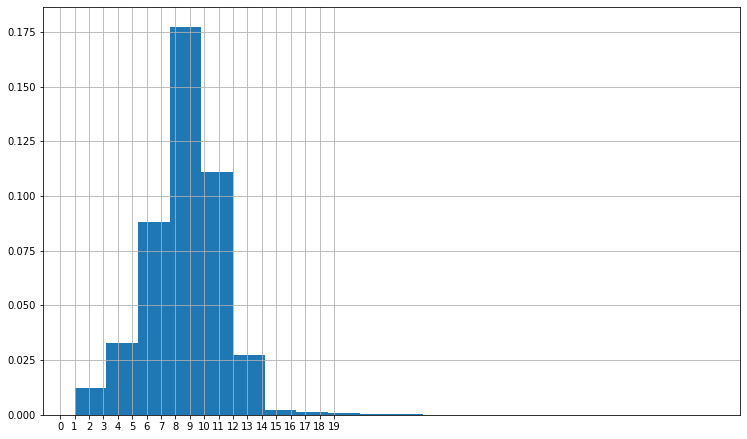

In [18]:
plt.figure(figsize = (12.5, 7.5))
plt.xticks(np.arange(20))
plt.hist(tokens_hist, bins = 20, density = True)
plt.grid("y")

# Lets begin

In [18]:
import io
import itertools
import numpy as np
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [19]:
SEED = 42 
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    for sequence in tqdm.tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence, 
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
              tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1, 
              num_sampled=num_ns, 
              unique=True, 
              range_max=vocab_size, 
              seed=SEED, 
              name="negative_sampling")

          # Build context and label vectors (for one target word)
            negative_sampling_candidates = tf.expand_dims(
              negative_sampling_candidates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [21]:
text_ds = tf.data.TextLineDataset("titles.txt").filter(lambda x: tf.cast(tf.strings.length(x), bool))

## Vectorize sentences from the corpus

In [28]:
# We create a custom standardization function to lowercase the text and 
# remove punctuation.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

# Define the vocabulary size and number of words in a sequence.
vocab_size = 8192 + 4096
sequence_length = 12

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [29]:
vectorize_layer.adapt(text_ds.batch(1024))

In [30]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'de', 'kit', 'para', 'tenis', 'com', 'infantil', 'e', 'feminino', 'masculino', '2', 'celular', '4', 'original', 'xiaomi', 'led', '3', 'samsung', '10']


In [31]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(vectorize_layer(text))

# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [32]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

6967053


In [33]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 184 2766  393 3726  123 2280    1 2248 4092    2    1    0] => ['casa', 'sola', 'en', 'venta', 'con', 'gran', '[UNK]', 'solo', 'pago', 'de', '[UNK]', '']
[ 4692  4227 11247  3426   462   564   393     1     0     0     0     0] => ['resident', 'evil', 'origins', 'collection', 'nintendo', 'switch', 'en', '[UNK]', '', '', '', '']
[4787    2    1  880  638    0    0    0    0    0    0    0] => ['falda', 'de', '[UNK]', 'piel', 'negra', '', '', '', '', '', '', '']
[    1   578 10402  4455  2620  5897   618  7807     0     0     0     0] => ['[UNK]', 'red', 'devil', 'radeon', 'rx', '580', '8gb', 'gddr5', '', '', '', '']
[ 672  291    1  567 2036  123 8657    1 1573   25    0    0] => ['laptop', 'hp', '[UNK]', 'core', 'duo', 'con', 'puerto', '[UNK]', 'windows', '7', '', '']


In [34]:
num_ns = 4
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=num_ns, 
    vocab_size=vocab_size, 
    seed=SEED)

print(len(targets), len(contexts), len(labels))

100%|██████████| 6967053/6967053 [29:30<00:00, 3934.66it/s]  

20606275 20606275 20606275


### Train - test splits

In [73]:
N = len(targets)
val_size = .25
train_indxs, val_indxs = train_test_split(np.arange(N).astype(np.int), test_size = val_size)
print(train_indxs.size)
print(val_indxs.size)

6052252
2017418


In [74]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

targets_train = [targets[i] for i in train_indxs]
contexts_train = [contexts[i] for i in train_indxs]
labels_train = [labels[i] for i in train_indxs]

dataset_train = tf.data.Dataset.from_tensor_slices(((targets_train, contexts_train), labels_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset_train)

<PrefetchDataset shapes: (((1024,), (1024, 6, 1)), (1024, 6)), types: ((tf.int32, tf.int64), tf.int64)>


In [75]:
targets_val = [targets[i] for i in val_indxs]
contexts_val = [contexts[i] for i in val_indxs]
labels_val = [labels[i] for i in val_indxs]

dataset_val = tf.data.Dataset.from_tensor_slices(((targets_val, contexts_val), labels_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_val = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset_val)

<PrefetchDataset shapes: (((1024,), (1024, 6, 1)), (1024, 6)), types: ((tf.int32, tf.int64), tf.int64)>


### Whole dataset (for final training)

In [35]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [36]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


## Model and training

In [37]:
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim, num_ns):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size, 
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding", )
        self.context_embedding = Embedding(vocab_size, 
                                           embedding_dim, 
                                           input_length=num_ns+1)
        self.dots = Dot(axes=(3,2))
        self.flatten = Flatten()
        #sanity check
        print("num_ns: ", num_ns)
        print("embedding dim: ", embedding_dim)
        print("vocab_size: ", vocab_size)

    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

### Train final model

In [42]:
epochs = 15
embedding_dim = 16
word2vec = Word2Vec(vocab_size, embedding_dim, num_ns)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

h = word2vec.fit(dataset, epochs=epochs)

num_ns:  4
embedding dim:  16
vocab_size:  12288
Epoch 1/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.9455 - accuracy: 0.6308
Epoch 2/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7563 - accuracy: 0.7158
Epoch 3/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7270 - accuracy: 0.7273
Epoch 4/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7170 - accuracy: 0.7312
Epoch 5/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7119 - accuracy: 0.7331
Epoch 6/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7085 - accuracy: 0.7344
Epoch 7/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7062 - accuracy: 0.7353
Epoch 8/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7044 - accuracy: 0.7359
Epoch 9/15
20123/20123 [==============================] - 78s 4ms/step - loss: 0.7030 - accuracy: 0.7364
Epoch 

In [43]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [44]:
out_v = io.open('vectors_q_16.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_q_16.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [41]:
!ls -l --block-size=M

total 203M
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne   1M Nov 25 20:05 meta_q.tsv
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne   1M Nov 24 14:58 meta_tit_32.tsv
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne 197M Nov 25 18:38 titles.txt
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne   5M Nov 25 20:05 vectors_q.tsv
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne   2M Nov 24 14:58 vectors_tit_32.tsv
-rw-r--r--. 1 guillermo.etchebarne guillermo.etchebarne   1M Nov 23 18:47 word2vec.ipynb
-rw-rw-r--. 1 guillermo.etchebarne guillermo.etchebarne   1M Nov 25 20:04 word2vec_items.ipynb
